## Incremental Kernel Inverse Update in Gaussian Process Regression

To efficiently update the inverse of the kernel matrix when new data points are added, we use a blockwise inverse formula derived from the **Sherman–Morrison–Woodbury identity**.

Suppose the current inverse of the kernel matrix is known:
$$
K_{NN}^{-1} \in \mathbb{R}^{N \times N}
$$
and we want to augment it with $M$ new data points, leading to an extended kernel matrix:
$$
K_{N+M,N+M} =
\begin{bmatrix}
K_{NN} & B \\
C & D
\end{bmatrix}
$$
where:
- $B \in \mathbb{R}^{N \times M}$ is the cross-covariance between old and new points,
- $C = B^\top \in \mathbb{R}^{M \times N}$,
- $D \in \mathbb{R}^{M \times M}$ is the covariance of the new points.

Then, the inverse of the augmented matrix is given by:
$$
K_{N+M,N+M}^{-1} =
\begin{bmatrix}
K_{NN}^{-1} + K_{NN}^{-1} B S^{-1} C K_{NN}^{-1} & -K_{NN}^{-1} B S^{-1} \\
- S^{-1} C K_{NN}^{-1} & S^{-1}
\end{bmatrix}
$$
where:
$$
S = D - C K_{NN}^{-1} B
$$
is the Schur complement of $K_{NN}$ in the augmented matrix.

### Notation correspondence in code:
- `self.k_xx_inv`: corresponds to $K_{NN}^{-1}$
- `B`: corresponds to $B$
- `C = B^\top`: corresponds to $C$
- `D`: corresponds to $D$
- `temp = S^{-1}`

This incremental scheme allows efficient GP updates **without recomputing the full inverse**, with complexity $\mathcal{O}(NM^2 + M^3)$ instead of $\mathcal{O}(N+M)^3$.


In [1]:
import sys
sys.path.append(f"../../src/utils")

from preprocessing import preprocessing

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import GPy

from onlineGP import *
from modelF import coarse_model
from scipy.stats.qmc import LatinHypercube
from scipy.stats import norm
import pickle

from scipy.stats import gaussian_kde
import arviz as az


#Try with TinyDA
import tinyDA as tda
from scipy.stats import multivariate_normal

# Local module imports
sys.path.append('../../src/SurrogateModeling')
sys.path.append('../../src/InverseProblems')
sys.path.append('../../src/utils')

from utils import * 


 /Users/filippozacchei/anaconda3/envs/progIEVA/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning:IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2025-04-17 09:24:16,802	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Import

In [2]:
# Markov Chain Monte Carlo (MCMC) Configuration
MCMC_SETTINGS = {
    'parameter_start_points': [
        np.array([0.3, 0.0, 30.0]),
        np.array([0.4, 0.25, 30.0]),
        np.array([0.2, 0.25, 30.0]),
        np.array([0.4, -0.25, 30.0]),
        np.array([0.2, -0.25, 30.0])
    ],
    'bounds': ([0.1, -0.5, 29.0], [0.5, 0.5, 31.0]),
    'N': int(6e3),   # Total number of samples
    'Nb': int(1e3),  # Number of burn-in samples
    'Nt': 5,         # Number of chains
}

# Noise Configuration
NOISE_PARAMS = {
    'noise_factor': 1e-6 * 10000,
    'B': np.sqrt(200),
    'S': 5,
}

noise = (NOISE_PARAMS['noise_factor']*NOISE_PARAMS['B']*NOISE_PARAMS['S'])**2


In [3]:
print(noise)

0.4999999999999999


In [4]:
# Carica tutti i modelli usando load_model
nsamples = 50
A = np.load(f"data/gp_svd_decomposition_{nsamples}.npz", allow_pickle=True)
Z_r = A['Z_r']  # (640, r)
X_mean = A['X_mean']  # (640, d)
X_std = A['X_std']  # (640, d)
Y_std = A['Y_std']  # (640, d)
Y_min = A['Y_min']

GP_models = []
for t in range(5):  # Per tutti i time steps
    # Open the file in binary read mode ('rb')
    with open(f"./SVD_GP_models/GP_models_matern_{t}_{nsamples}.pkl", 'rb') as f:
        # Load the model using pickle.load() with encoding
        model = pickle.load(f, fix_imports=True, encoding='latin1')
    GP_models.append(model)

In [5]:
nsamples_inverse = 10

num_dimensions = 3  # Number of parameters
seed = 44
sampler = LatinHypercube(d=3, seed=seed)
lhs_samples = sampler.random(n=nsamples_inverse)

# Scale the samples to the desired ranges for each parameter
param_ranges = [(0.1, 0.5), (-0.5, 0.5), (29, 31)]  # Define ranges for each parameter
random_parameters = lhs_samples.copy()

for i, (low, high) in enumerate(param_ranges):
    random_parameters[:, i] = low + (high - low) * lhs_samples[:, i]
    X = random_parameters
    
Y = np.array([coarse_model(X[i,:]) for i in range(nsamples_inverse)])
sample = 1

In [6]:
class CustomUniform:
    def __init__(self, lower_bound, upper_bound):
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.area = np.prod(self.upper_bound - self.lower_bound)
    
    def pdf(self, x):
        if (self.lower_bound <= x).all() & (x <= self.upper_bound).all():
            return 1 / self.area
        else:
            return 0
        
    def logpdf(self, x):  
        if (self.pdf(x)!=0): 
            return np.log(self.pdf(x)) 
        else:
            return -np.inf
    
    def rvs(self):
        return np.random.uniform(self.lower_bound, self.upper_bound)



In [7]:
# Select a true sample for testing
x_true, y_true = X[sample], Y[sample]
print(x_true)
# Generate observed data by adding Gaussian noise to the true data
y_observed = y_true + np.random.normal(scale=noise,size=y_true.shape[0]) # ADDED

# Define the prior distribution for the input parameters
# Assuming uniform distributions over specified ranges for each parameter
# = uniform(loc=np.array([0.1, -0.5, 29.0]), scale=np.array([0.5, 0.5, 31.0]) - np.array([0.1, -0.5, 29.0])) #ADDED
x_distribution = CustomUniform(np.array([0.1, -0.5, 29.0]), np.array([0.5, 0.5, 31.0]))

# Pass the sampled input to the forward model
# set the likelihood
cov_likelihood = noise * np.eye(len(Y[0,:]))
y_distribution = tda.GaussianLogLike(y_observed, cov_likelihood) 

[ 0.34123264 -0.21623171 30.62854127]


In [8]:
# Initialize a list to hold the optimized parameters for each start point
initial_guesses = []

forward_model = coarse_model

# Display the true parameters for reference
print("Real Params: ", x_true)

# Iterate over each parameter start point to perform optimization
for index, start_point in enumerate(MCMC_SETTINGS['parameter_start_points']):
    # Perform least squares optimization given the observed data, forward model,
    # start point, and parameter bounds
    optimized_params, covariance_matrix = least_squares_optimization(
        y_observed=y_observed, 
        forward_model=forward_model, 
        start_point=start_point, 
        bounds=MCMC_SETTINGS['bounds']
    )

    # Append the optimized parameters to the list of initial guesses
    initial_guesses.append(optimized_params)

    # Print the optimized parameters for this iteration
    print(f"Optimized Params {index + 1}: {optimized_params}")


Real Params:  [ 0.34123264 -0.21623171 30.62854127]
Optimized Params 1: [ 0.34810512 -0.21701746 31.        ]
Optimized Params 2: [ 0.34810511 -0.21701745 31.        ]
Optimized Params 3: [ 0.34810512 -0.21701746 31.        ]
Optimized Params 4: [ 0.34810512 -0.21701745 31.        ]
Optimized Params 5: [ 0.34810511 -0.21701745 31.        ]


 <>:8: SyntaxWarning:invalid escape sequence '\D'
 <>:8: SyntaxWarning:invalid escape sequence '\D'
 /var/folders/4s/l1d335rn5k19twqx3g8v_9140000gn/T/ipykernel_15194/3608564696.py:8: SyntaxWarning:invalid escape sequence '\D'


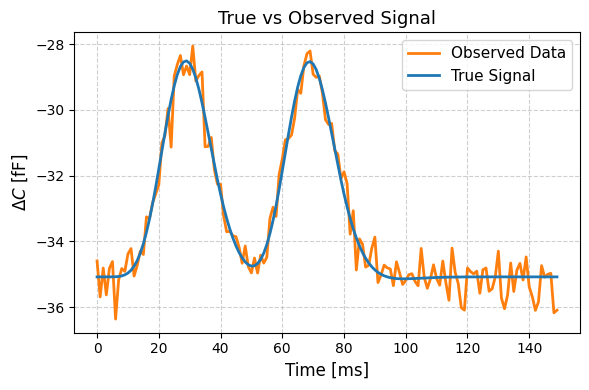

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(y_observed, label='Observed Data', linestyle='-', linewidth=2, color='tab:orange')
plt.plot(y_true, label='True Signal', linestyle='-', linewidth=2, color='tab:blue')

plt.xlabel("Time [ms]", fontsize=12)
plt.ylabel(f"$\Delta C$ [fF]", fontsize=12)
plt.title("True vs Observed Signal", fontsize=13)
plt.legend(fontsize=11)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("signal_comparison.pdf", format='pdf', dpi=300)  # Save for publication
plt.show()

## Delayed Acceptace



In [10]:
def gp_predict_z_mean_std(u_centered):
    """
    Predict all latent GP modes (z_pred) and stds (z_std) for a single input.
    """
    z_pred = np.empty(len(GP_models))
    z_std = np.empty(len(GP_models))
    u_input = u_centered.reshape(1, -1)
    for i, model in enumerate(GP_models):
        mu, sigma = model.predict(u_input)
        z_pred[i] = mu[0]
        z_std[i] = sigma[0]
    return z_pred, z_std

def gp_forward_model(u):
    u_centered = (u - X_mean) / X_std
    z_pred, _ = gp_predict_z_mean_std(u_centered)
    y_mean = (Z_r @ z_pred) * Y_std + Y_min
    return y_mean

def gp_covariance(u):
    u_centered = (u - X_mean) / X_std
    _, z_std = gp_predict_z_mean_std(u_centered)
    cov_gp = Z_r @ np.diag(z_std**2) @ Z_r.T
    cov_y = np.diag(np.diag(cov_gp)) * (Y_std ** 2)
    return cov_y
from scipy.stats import multivariate_normal

class GP_LogLikelihood:
    def __init__(self, y_obs, total_cov):
        self.y_obs = y_obs
        self.total_cov = total_cov

    def loglike(self, model_output):
        return multivariate_normal.logpdf(self.y_obs, mean=model_output, cov=self.total_cov)
    
y_distr_coarse = GP_LogLikelihood(y_observed, cov_likelihood)
y_distr_fine   = tda.GaussianLogLike(y_observed, cov_likelihood)

my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse, gp_forward_model)
my_posterior_fine   = tda.Posterior(x_distribution, y_distr_fine, forward_model)

my_posteriors = [my_posterior_coarse, my_posterior_fine]

In [11]:
import matplotlib.pyplot as plt
from scipy.stats import norm

def plot_gp_prediction_with_uncertainty(x_input, y_true_signal, title="GP prediction"):
    """
    Plot the GP-predicted signal at input x_input with uncertainty bounds.
    
    Parameters:
        x_input: parameter vector (unnormalized)
        y_true_signal: ground truth signal (used for comparison)
        title: optional plot title
    """

    # Center the input for GP
    x_centered = (x_input - X_mean) / X_std

    # GP predictions in latent space
    z_pred = []
    z_std = []

    for model in GP_models:
        mu, sigma = model.predict(x_centered.reshape(1, -1))
        z_pred.append(mu[0])
        z_std.append(sigma[0])

    z_pred = np.array(z_pred)
    z_std = np.array(z_std)

    # Reconstruct signal from latent prediction
    y_pred = (Z_r @ z_pred) * Y_std + Y_min  # (150,)
    
    # Compute predictive covariance in signal space
    cov_gp = Z_r @ np.diag(z_std**2) @ Z_r.T
    std_pred = np.sqrt(np.diag(cov_gp)) * Y_std  # (150,)

    # 95% confidence intervals
    z_score = norm.ppf(0.975)
    y_lower = y_pred - z_score * std_pred
    y_upper = y_pred + z_score * std_pred

    # Plot
    time = np.arange(len(y_pred))
    plt.figure(figsize=(8, 4))
    plt.plot(time, y_pred, label="GP Prediction", color="blue", linewidth=2)
    plt.fill_between(time, y_lower, y_upper, color="blue", alpha=0.2, label="95% Confidence Interval")
    plt.plot(time, y_true_signal, label="True Signal", color="red", linestyle="--", linewidth=1)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Output Value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Call this just after the DA loop


🎯 Sample 0, True parameters: [ 0.29509738 -0.42581131 29.51884585]


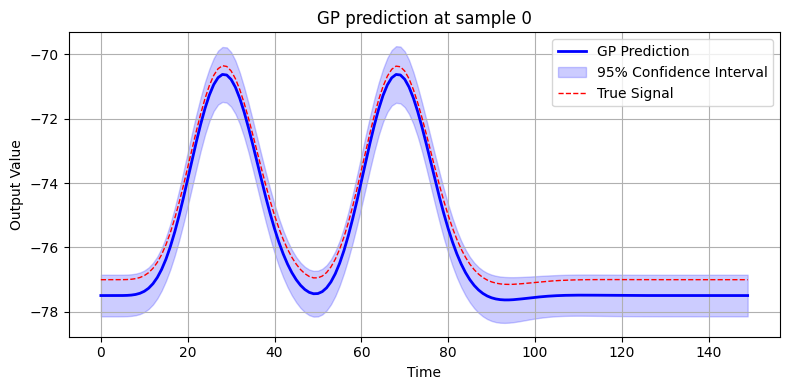

🔁 Iteration 0, max GP std = inf
Sampling chain 1/1


Running chain, α_c = 0.333, α_f = 0.40: 100%|██████████| 5/5 [00:01<00:00,  4.03it/s]
 /Users/filippozacchei/anaconda3/envs/progIEVA/lib/python3.12/site-packages/arviz/data/inference_data.py:157: UserWarning:qoi group is not defined in the InferenceData scheme


📌 Last sample: [ 0.29440545 -0.41332498 30.51600788]
622918.1414310796
1677052.0576678813
1767851.9774219997
1767851.9774219997
1767851.9774219997


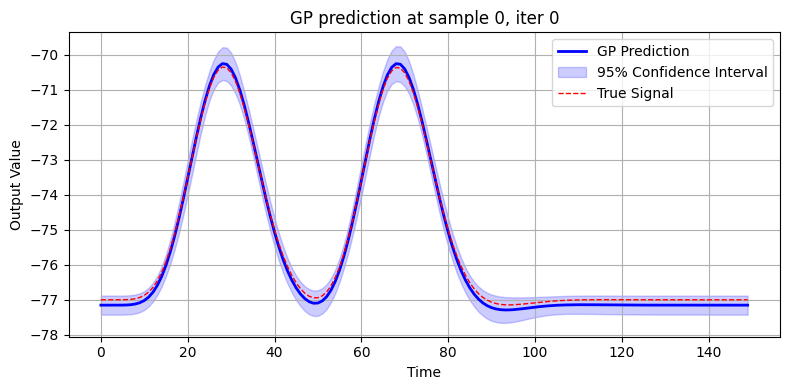

🔁 Iteration 1, max GP std = 5.00e-03
Sampling chain 1/1


Running chain, α_c = 0.667, α_f = 0.60: 100%|██████████| 5/5 [00:01<00:00,  3.52it/s]

📌 Last sample: [ 0.29686787 -0.41111272 30.88084456]
803808.3555760566
1739982.4077864718
1806086.3408626239
1806086.3408626239
1806086.3408626239


<Figure size 640x480 with 0 Axes>

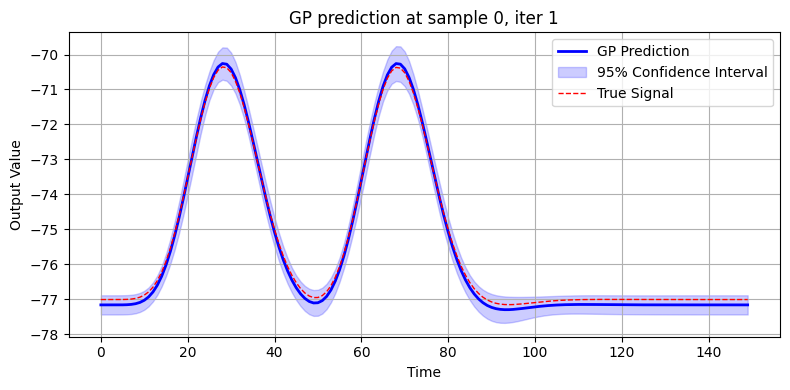

🔁 Iteration 2, max GP std = 4.98e-03
Sampling chain 1/1


Running chain, α_c = 0.778, α_f = 0.80: 100%|██████████| 5/5 [00:01<00:00,  3.54it/s]

📌 Last sample: [ 0.29443217 -0.41339358 30.50663765]
1263933.5691259517
1817323.9495996023
1841718.3644129755
1841718.3644129755
1841718.3644129755


<Figure size 640x480 with 0 Axes>

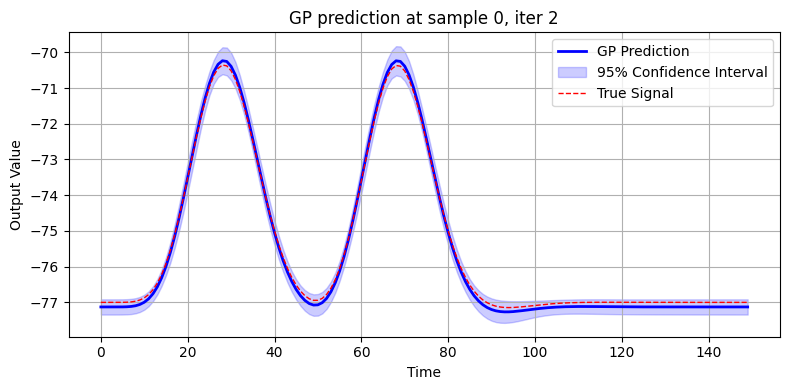

🔁 Iteration 3, max GP std = 3.59e-03
Sampling chain 1/1


Running chain, α_c = 0.667, α_f = 0.60: 100%|██████████| 5/5 [00:01<00:00,  3.28it/s]

📌 Last sample: [ 0.29724373 -0.41382491 30.67778863]
1287165.0106847591
1867489.3597910875
1878651.5987436222
1878651.5987436222
1878651.5987436222


<Figure size 640x480 with 0 Axes>

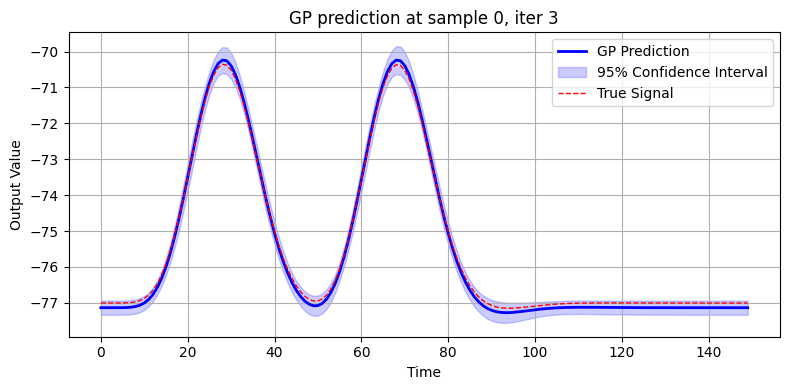

🔁 Iteration 4, max GP std = 3.34e-03
Sampling chain 1/1


Running chain, α_c = 0.889, α_f = 0.80: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

📌 Last sample: [ 0.30038925 -0.41385991 30.90484493]
1310911.6401154527
1932795.0517261543
1919608.2197452423
1919608.2197452423
1919608.2197452423


<Figure size 640x480 with 0 Axes>

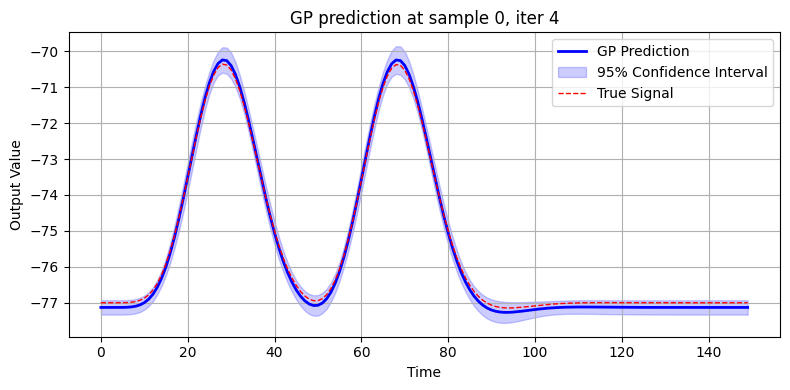

🔁 Iteration 5, max GP std = 3.33e-03
Sampling chain 1/1


Running chain, α_c = 0.556, α_f = 0.60: 100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

📌 Last sample: [ 0.29896891 -0.41474453 30.72633165]
1336779.0202401704
1973632.782857423
1955381.0373486795
1955381.0373486795
1955381.0373486795


<Figure size 640x480 with 0 Axes>

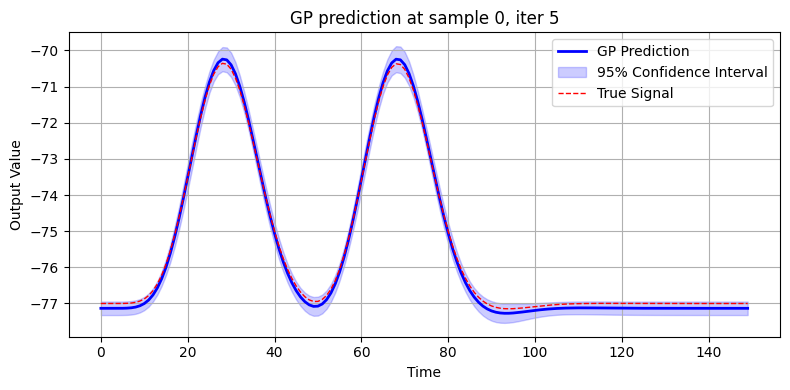

🔁 Iteration 6, max GP std = 3.22e-03
Sampling chain 1/1


Running chain, α_c = 0.778, α_f = 0.80: 100%|██████████| 5/5 [00:01<00:00,  3.61it/s]

📌 Last sample: [ 0.29606195 -0.41436635 30.54251119]
1369536.6047764695
2018151.8468799447
2024629.35235954
2024629.35235954
2024629.35235954


<Figure size 640x480 with 0 Axes>

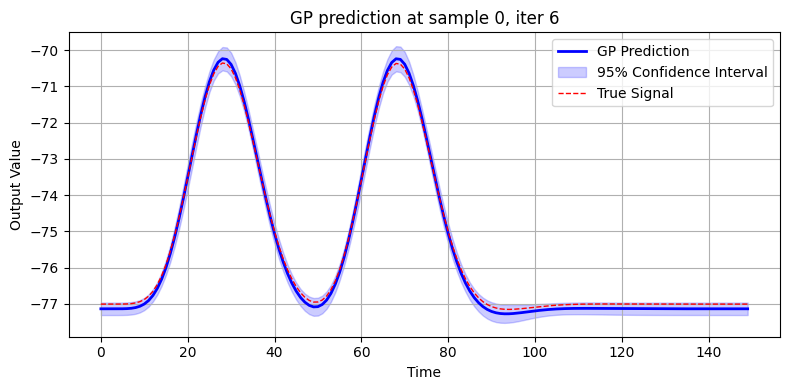

🔁 Iteration 7, max GP std = 2.85e-03
Sampling chain 1/1


Running chain, α_c = 0.667, α_f = 0.60: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]

📌 Last sample: [ 0.29424761 -0.4162393  30.25140493]
1395199.6666258986
2069200.6828141613
2063829.4624992774
2063829.4624992774
2063829.4624992774


<Figure size 640x480 with 0 Axes>

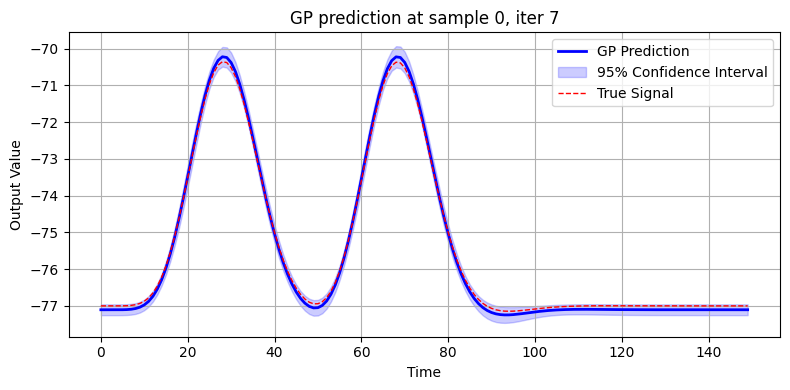

🔁 Iteration 8, max GP std = 2.40e-03
Sampling chain 1/1


Running chain, α_c = 0.556, α_f = 0.60: 100%|██████████| 5/5 [00:01<00:00,  3.45it/s]


📌 Last sample: [ 0.29581601 -0.41266514 30.67243568]
1429833.3351781082
2108831.4214305542
2128756.2941681724
2128756.2941681724
2128756.2941681724


<Figure size 640x480 with 0 Axes>

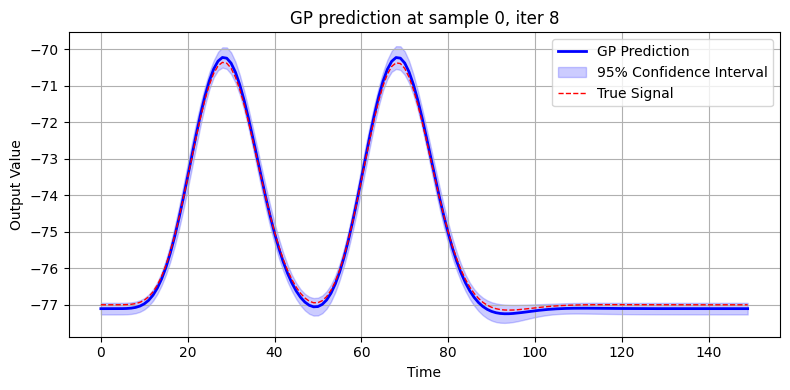

🔁 Iteration 9, max GP std = 2.36e-03
Sampling chain 1/1


Running chain, α_c = 1.000, α_f = 1.00: 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

📌 Last sample: [ 0.29719222 -0.41338483 30.70385748]
1458083.6892856671
2149612.676431746
2172636.648196677
2172636.648196677
2172636.648196677


<Figure size 640x480 with 0 Axes>

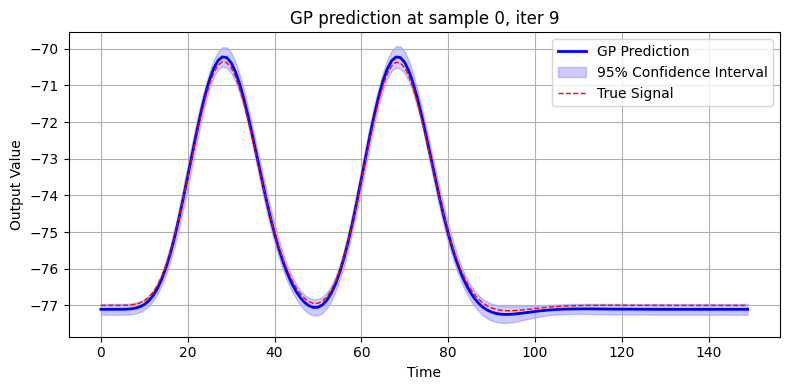

🔁 Iteration 10, max GP std = 2.18e-03
Sampling chain 1/1


Running chain, α_c = 1.000, α_f = 1.00: 100%|██████████| 5/5 [00:01<00:00,  3.46it/s]

📌 Last sample: [ 0.29656508 -0.41456378 30.56596672]
1485762.376701022
2188922.4669911135
2209694.3976337085
2209694.3976337085
2209694.3976337085


<Figure size 640x480 with 0 Axes>

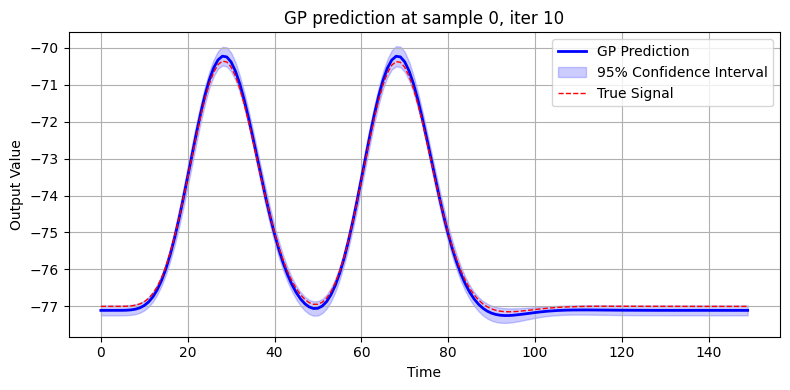

🔁 Iteration 11, max GP std = 2.18e-03
Sampling chain 1/1


Running chain, α_c = 0.778, α_f = 0.80: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]

📌 Last sample: [ 0.29661199 -0.41135289 30.84238706]
1516922.568169102
2244694.100522758
2253887.923396539
2253887.923396539
2253887.923396539


<Figure size 640x480 with 0 Axes>

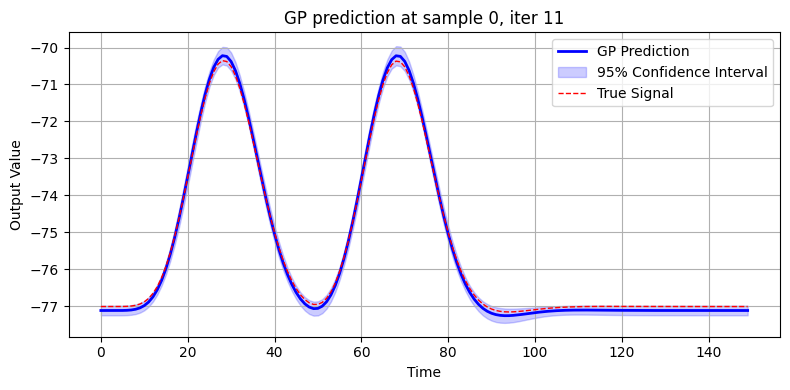

🔁 Iteration 12, max GP std = 2.08e-03
Sampling chain 1/1


Running chain, α_c = 0.556, α_f = 0.60: 100%|██████████| 5/5 [00:01<00:00,  3.49it/s]

📌 Last sample: [ 0.29765768 -0.41213859 30.84550932]
1546504.834507441
2299660.7572918823
2306388.0721637583
2306388.0721637583
2306388.0721637583


<Figure size 640x480 with 0 Axes>

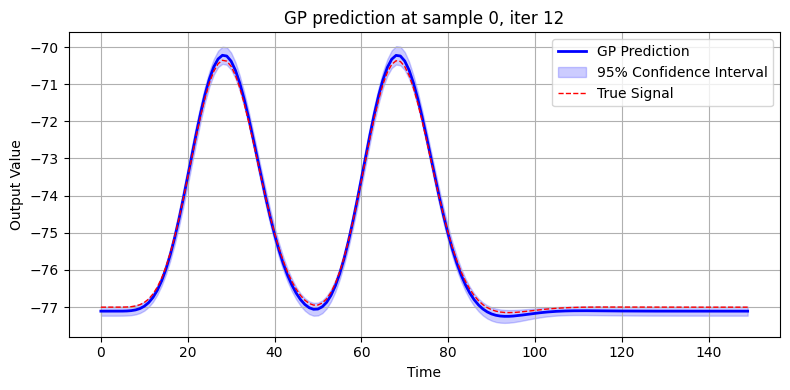

🔁 Iteration 13, max GP std = 2.04e-03
Sampling chain 1/1


Running chain, α_c = 0.778, α_f = 0.80: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]

📌 Last sample: [ 0.30008676 -0.41489853 30.78556183]
1575136.0060173643
2348771.8843593607
2384189.556122297
2384189.556122297
2384189.556122297


<Figure size 640x480 with 0 Axes>

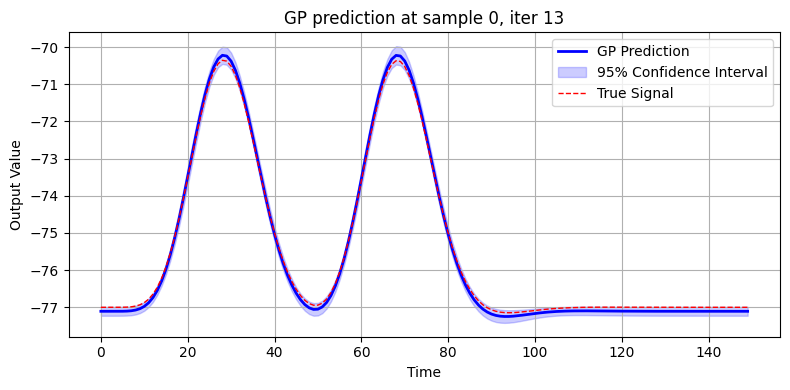

🔁 Iteration 14, max GP std = 2.01e-03
Sampling chain 1/1


Running chain, α_c = 0.778, α_f = 0.80: 100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

📌 Last sample: [ 0.30235006 -0.41463036 30.97827914]
1604774.3342297734
2448907.4881102885
2444666.581872513
2444666.581872513
2444666.581872513


<Figure size 640x480 with 0 Axes>

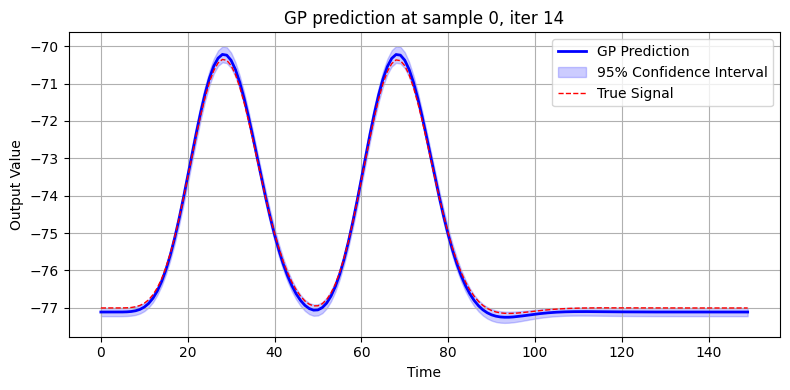

🔁 Iteration 15, max GP std = 2.03e-03
Sampling chain 1/1


Running chain, α_c = 0.778, α_f = 0.80: 100%|██████████| 5/5 [00:01<00:00,  3.69it/s]


📌 Last sample: [ 0.30040346 -0.41457186 30.84070254]
1634881.6237188166
2502566.552142246
2550046.8090831605
2550046.8090831605
2550046.8090831605


<Figure size 640x480 with 0 Axes>

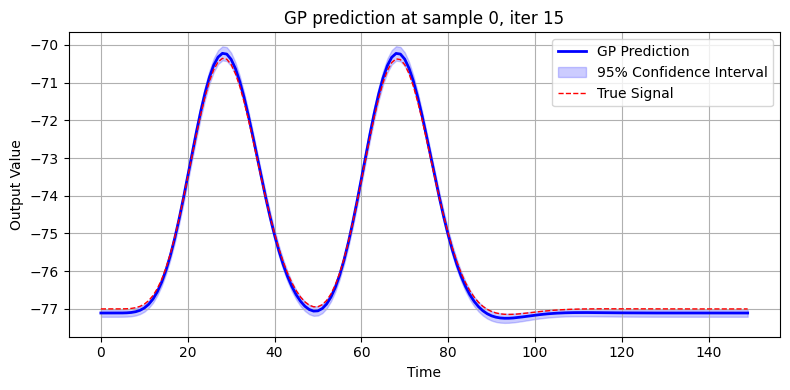

🔁 Iteration 16, max GP std = 2.01e-03
Sampling chain 1/1


Running chain, α_c = 0.556, α_f = 0.60: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


📌 Last sample: [ 0.29893633 -0.41731227 30.50652084]
1664768.3708674312
2573766.7402586266
2774156.613427648
2774156.613427648
2774156.613427648


<Figure size 640x480 with 0 Axes>

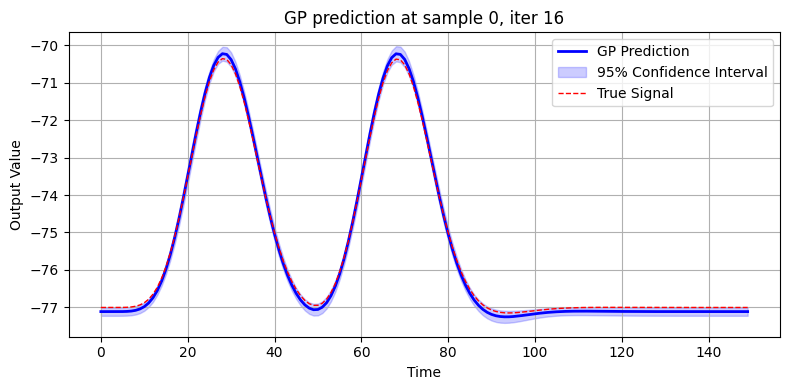

🔁 Iteration 17, max GP std = 1.93e-03
Sampling chain 1/1


Running chain, α_c = 1.000, α_f = 1.00: 100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


📌 Last sample: [ 0.29374777 -0.4152371  30.30164487]
1699503.9630102117
2695993.691272241
2945196.162331814
2945196.162331814
2945196.162331814


<Figure size 640x480 with 0 Axes>

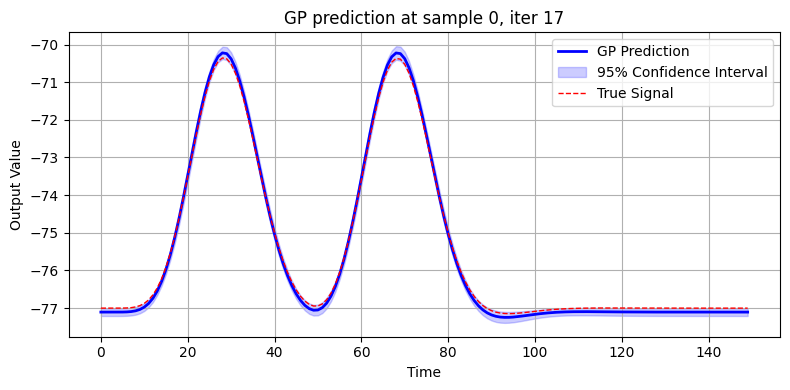

🔁 Iteration 18, max GP std = 1.84e-03
Sampling chain 1/1


Running chain, α_c = 0.333, α_f = 0.40: 100%|██████████| 5/5 [00:01<00:00,  3.58it/s]


📌 Last sample: [ 0.29358548 -0.41084285 30.66181089]
1755128.4759945588
2802367.991827568
3140252.1020427756
3140252.1020427756
3140252.1020427756


<Figure size 640x480 with 0 Axes>

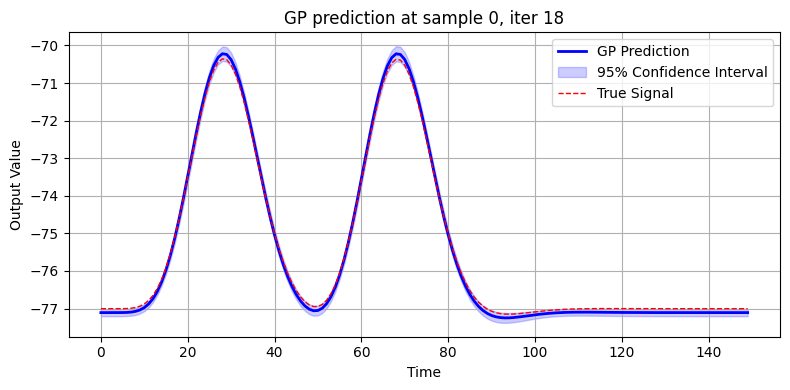

🔁 Iteration 19, max GP std = 1.70e-03
Sampling chain 1/1


Running chain, α_c = 1.000, α_f = 1.00: 100%|██████████| 5/5 [00:01<00:00,  3.55it/s]


📌 Last sample: [ 0.29275994 -0.41183141 30.51654729]
1794041.100727666
2914321.262924128
3306217.854186482
3306217.854186482
3306217.854186482


<Figure size 640x480 with 0 Axes>

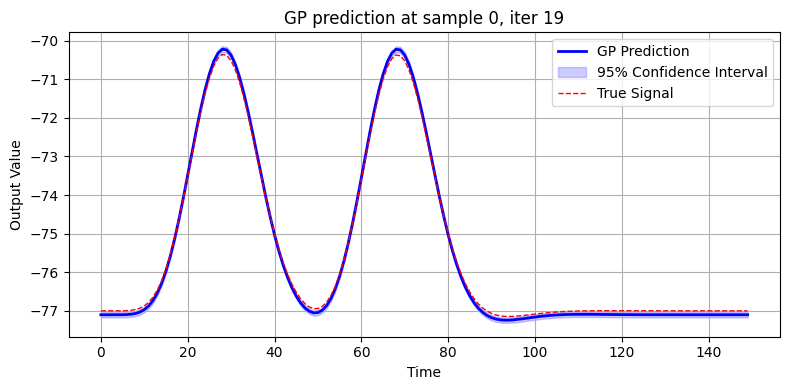

🔁 Iteration 20, max GP std = 1.62e-03
Sampling chain 1/1


Running chain, α_c = 0.778, α_f = 0.80: 100%|██████████| 5/5 [00:01<00:00,  3.80it/s]


📌 Last sample: [ 0.29126795 -0.41192649 30.39369373]
1827110.4230560926
3053531.615215645
3467074.368594669
3467074.368594669
3467074.368594669


<Figure size 640x480 with 0 Axes>

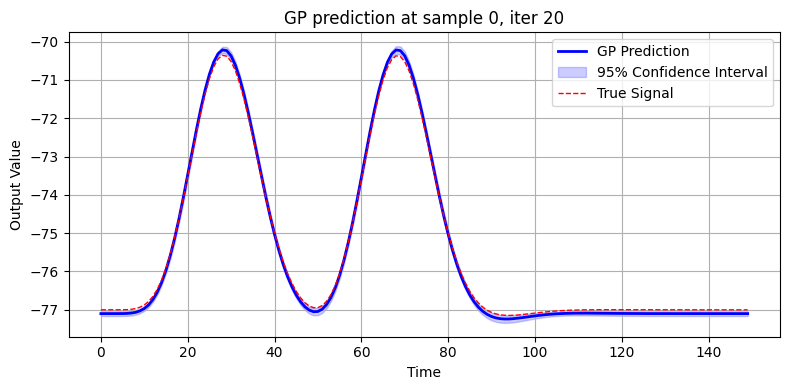

 /Users/filippozacchei/anaconda3/envs/progIEVA/lib/python3.12/site-packages/tinyDA/sampler.py:114: UserWarning: subsampling_rate has been deprecated in favour of subchain_length.


✅ GP confidence sufficient. Switching to GP-only inference.
Sampling chain 1/1


Running chain, α = 0.19: 100%|██████████| 1000/1000 [05:30<00:00,  3.03it/s]


<Figure size 640x480 with 0 Axes>

In [ ]:
samples_box = []

for s in range(1):
    # --- 1. Select true sample and simulate observation ---
    x_true, y_true = X[s], Y[s]
    print(f"\n🎯 Sample {s}, True parameters: {x_true}")
    
    y_observed = y_true + np.random.normal(scale=noise, size=y_true.shape[0])
    
    # Fine model likelihood
    y_distr_fine = tda.GaussianLogLike(y_observed, cov_likelihood)

    # --- 2. Least-squares initialization ---
    init_guess, cov_matrix = least_squares_optimization(
        y_observed=y_observed,
        forward_model=coarse_model,
        start_point=np.array([0.2, 0.25, 30.0]),
        bounds=MCMC_SETTINGS['bounds']
    )
    
    my_proposal = tda.GaussianRandomWalk(C=cov_matrix, scaling=0.1, adaptive=True)

    # --- 3. Initial plot
    plot_gp_prediction_with_uncertainty(x_input=init_guess, y_true_signal=y_true, title=f"GP prediction at sample {s}")

    # --- 4. Delayed Acceptance Loop ---
    max_gp_std = np.inf
    iteration = 0
    last_sample = init_guess

    while max_gp_std > 1e-3:
        cov_gp = gp_covariance(init_guess)
        total_cov = cov_likelihood + cov_gp
        y_distr_coarse = GP_LogLikelihood(y_observed, total_cov)

        # Build posteriors
        my_posterior_coarse = tda.Posterior(x_distribution, y_distr_coarse, gp_forward_model)
        my_posterior_fine   = tda.Posterior(x_distribution, y_distr_fine, forward_model)
        my_posteriors = [my_posterior_coarse, my_posterior_fine]

        print(f"🔁 Iteration {iteration}, max GP std = {max_gp_std:.2e}")

        # Sample via Delayed Acceptance
        samples = tda.sample(
            my_posteriors,
            my_proposal,
            iterations=5,
            n_chains=1,
            initial_parameters=last_sample,
            subchain_length=1
        )

        # Convert to inference data
        idata = tda.to_inference_data(samples, level='fine', parameter_names=['Overetch', 'Offset', 'Thickness'])
        idata = idata.sel(draw=slice(0, None, 1))  # optional thinning

        # Extract last sample as vector
        last_sample = np.array([
            idata.posterior["Overetch"].values[0, -1],
            idata.posterior["Offset"].values[0, -1],
            idata.posterior["Thickness"].values[0, -1]
        ])

        print(f"📌 Last sample: {last_sample}")

        # --- 5. Online GP refinement ---
        new_data_centered = (last_sample - X_mean) / X_std  # shape (d,)
        y_data = coarse_model(last_sample)                  # shape (T,)
        y_data_centered = Z_r.T @ ((y_data - Y_min) / Y_std)  # shape (r,)

        for i in range(len(GP_models)):
            GP_models[i].fit(
                new_data_centered.reshape(1, -1),
                np.array([[y_data_centered[i]]]),
                optimize_scales=False
            )

        # Optional: track progress
        plot_gp_prediction_with_uncertainty(
            x_input=init_guess,
            y_true_signal=y_true,
            title=f"GP prediction at sample {s}, iter {iteration}"
        )
        plt.savefig(f'iteration_f_{iteration}.png', format='png', dpi=300)  # Save for publication
        init_guess_centered = (init_guess - X_mean) / X_std
        # Update stopping criterion
        max_gp_std = np.max(gp_predict_z_mean_std(init_guess_centered)[1])
        iteration += 1

    # --- 6. Final inference with GP only ---
    print("✅ GP confidence sufficient. Switching to GP-only inference.")
    samples_gp_only = tda.sample(
        [my_posterior_coarse],
        my_proposal,
        iterations=1000,
        n_chains=1,
        initial_parameters=init_guess,
        subsampling_rate=1
    )
    idata_gp = tda.to_inference_data(
        samples_gp_only,
        level='coarse',
        parameter_names=['Overetch', 'Offset', 'Thickness']
    )
    
    samples_box.append(idata_gp)

In [16]:
new_data_centered

array([-0.33448597, -1.34558194,  0.6280149 ])

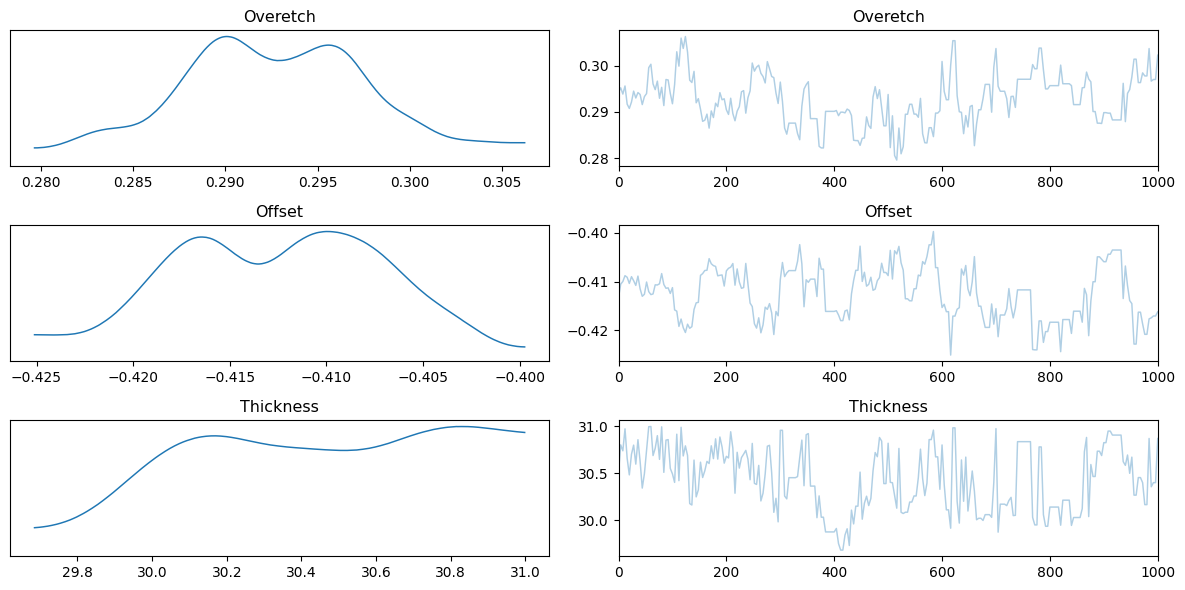

<Figure size 640x480 with 0 Axes>

In [19]:
# Plot trace of the first set of samples
#idata =         
idata_gp2 = idata_gp.sel(draw=slice(0, None, 4))  # optional thinning
az.plot_trace(idata_gp2)
plt.tight_layout()
plt.show()
plt.savefig("trace_plot.pdf", format='pdf', dpi=300)  # Save for publication


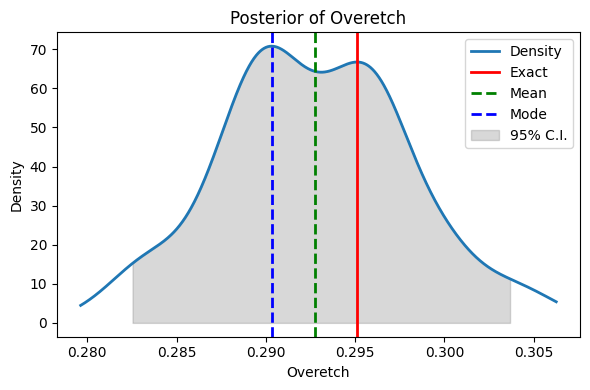

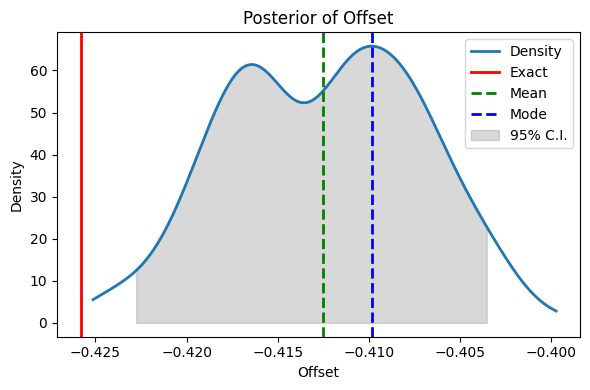

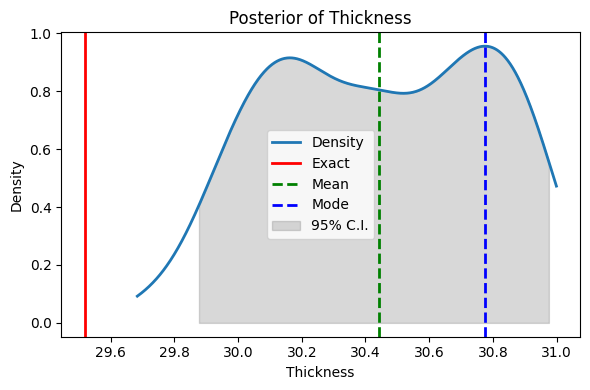

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def plot_parameter_distribution(parameter_samples, x_true, parameter_name):
    plt.figure(figsize=(6, 4))
    kernel_density = gaussian_kde(parameter_samples)
    x_range = np.linspace(np.min(parameter_samples), np.max(parameter_samples), 1000)
    plt.plot(x_range, kernel_density(x_range), label='Density', linewidth=2)
    plt.axvline(x_true, color='red', label='Exact', linestyle='-', linewidth=2)
    mean = np.mean(parameter_samples)
    mode = x_range[np.argmax(kernel_density(x_range))]
    plt.axvline(mean, color='green', label='Mean', linestyle='--', linewidth=2)
    plt.axvline(mode, color='blue', label='Mode', linestyle='--', linewidth=2)
    lower_bound, upper_bound = np.percentile(parameter_samples, [2.5, 97.5])
    plt.fill_between(
        x_range, 0, kernel_density(x_range),
        where=((x_range >= lower_bound) & (x_range <= upper_bound)),
        alpha=0.3, color='gray', label='95% C.I.'
    )
    plt.xlabel(parameter_name)
    plt.ylabel('Density')
    plt.legend()
    plt.title(f"Posterior of {parameter_name}")
    plt.tight_layout()
    plt.show()

# Extract samples correctly from idata_gp2
param_names = ['Overetch', 'Offset', 'Thickness']
for j, param in enumerate(param_names):
    samples = idata_gp2.posterior[param].values.flatten()
    plot_parameter_distribution(samples, x_true[j], param)